<a href="https://colab.research.google.com/github/ZeXuan0512/Weather-Advisor/blob/main/Weather_Advisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Configuration

In [2]:
!pip install python-dotenv

In [3]:
import os
from dotenv import load_dotenv
import requests
import pandas as pd
import logging
import time
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
# --- Upload env to colab ---
try:
    from google.colab import files
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    uploaded = files.upload()  # This opens the file picker in Colab
else:
    print(".env file must be placed in the same directory when running locally.")

Saving .env to .env


In [5]:
load_dotenv(".env")

True

# Weather Data Functions

In [6]:
cache = {}

def get_weather_data(location, forecast_days=5):
    current_time = time.time()
    cache_key = f"{location}-{forecast_days}"

    # Check if data is cached and not expired (valid for 10 minutes)
    if cache_key in cache and current_time - cache[cache_key]['timestamp'] < 600:
        return cache[cache_key]['data']

    # Initialize the output data structure
    parsed_data = {
        "current": [],
        "forecast": []
    }

    try:
        # --- API Call Setup ---
        url = "http://api.weatherapi.com/v1/forecast.json"
        api_key = os.getenv("WEATHER_API_KEY")
        params = {
            "q": location,
            "key": api_key,
            "days": forecast_days
        }
        resp = requests.get(url, params=params)

        # --- Check API response ---
        if resp.status_code == 200:
            try:
                # Parse the response only once
                response_data = resp.json()

                # Process current weather data
                current_data = response_data.get("current", {})
                if current_data:
                    parsed_data["current"].append({
                        "datetime": current_data.get("last_updated", "N/A"),
                        "weather condition": current_data.get("condition", {}).get("text", "N/A"),
                        "temperature": current_data.get("temp_c", "N/A"),
                        "wind speed": current_data.get("wind_kph", "N/A"),
                        "humidity": current_data.get("humidity", "N/A"),
                        "feelslike_c": current_data.get("feelslike_c", "N/A"),
                        "precipitation": current_data.get("precip_mm", "N/A"),
                    })

                # Process forecast data
                forecast_data = response_data.get("forecast", {}).get("forecastday", [])
                for item in forecast_data:
                    parsed_data["forecast"].append({
                        "datetime": item.get("date", "N/A"),
                        "weather condition": item.get("day", {}).get("condition", {}).get("text", "N/A"),
                        "temperature": item.get("day", {}).get("avgtemp_c", "N/A"),
                        "wind speed": item.get("day", {}).get("maxwind_kph", "N/A"),
                        "humidity": item.get("day", {}).get("avghumidity", "N/A"),
                        "rain percentage": item.get("day", {}).get("daily_chance_of_rain", "N/A"),
                        "precipitation": item.get("day", {}).get('totalprecip_mm', "N/A")
                    })

                # Save to cache only after successful processing
                cache[cache_key] = {
                    'data': parsed_data,
                    'timestamp': current_time
                }
                return parsed_data

            except (KeyError, TypeError) as e:
                error_message = f"Data parsing error: {str(e)}"
                logging.error(error_message)
                return {"error": error_message}

        else:
            # Log the error response
            error_msg = resp.json().get("message", "No message provided")
            logging.error(f"Error {resp.status_code}: {error_msg}")
            return {"error": f"API Error {resp.status_code}: {error_msg}"}

    except requests.RequestException as e:
        logging.error(f"Network error: {str(e)}")
        return {"error": f"Network error: {str(e)}"}

In [11]:
test_data = get_weather_data("Penang", forecast_days=5)
current_df = pd.DataFrame(test_data["current"])
forecast_df = pd.DataFrame(test_data["forecast"])

In [20]:
current_df

,datetime,weather condition,temperature,wind speed,humidity,feelslike_c,precipitation
0,2025-05-07 16:45,Patchy rain nearby,31.4,12.2,71,38.3,0.03


In [21]:
forecast_df

,datetime,weather condition,temperature,wind speed,humidity,rain percentage,precipitation
0,2025-05-07,Patchy rain nearby,28.1,13.7,76,89,4.4


# Visualisation Functions


In [7]:
def create_temperature_visualisation(weather_data, output_type='display'):
    # Step 1: Extract forecast dates and temperatures efficiently
    try:
        dates = [datetime.strptime(item['datetime'], "%Y-%m-%d") for item in weather_data["forecast"]]
        temperatures = [item['temperature'] for item in weather_data["forecast"]]

        # Step 2: Create the line graph
        fig, ax = plt.subplots(figsize=(8, 5))
        ax.plot(dates, temperatures, marker='o', linestyle='-', color='blue', label='Forecast Temperature (°C)')

        # Step 3: Set graph title and labels
        ax.set_title("Daily Temperature")
        ax.set_xlabel("Date")
        ax.set_ylabel("Temperature (°C)")
        ax.legend()
        ax.grid(True)

        # Step 4: Rotate x-ticks for better readability
        plt.xticks(rotation=45)

        # Step 5: Output the visualisation
        if output_type == 'figure':
            plt.close(fig)
            return fig
        else:
            plt.show()
            plt.close(fig)

    except KeyError as e:
        print(f"Missing key in weather data: {e}")
    except Exception as e:
        print(f"Error while generating the graph: {e}")

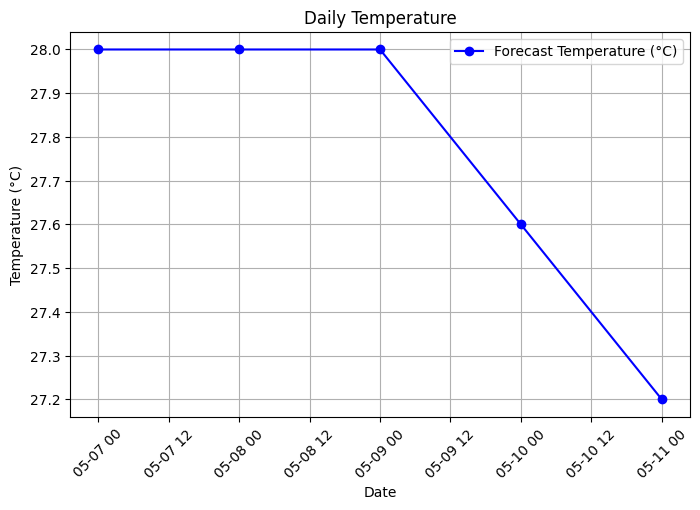

In [12]:
create_temperature_visualisation(test_data, output_type='display')